Импортируем необходимые библиотеки для работы над проектом

In [104]:
import numpy as np
import pandas as pd


import requests
from urllib.parse import urlencode

from scipy import stats
import pingouin as pg

import matplotlib.pyplot as plt
import seaborn as sns


%matplotlib inline

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


# Задача 1.

Написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока).

В начале изучим данные, на основе которых необходимо считать retention игроков
 - reg_data.csv – данные о времени регистрации
 - auth_data.csv – данные о времени захода пользователей в игру

In [2]:
reg_data = pd.read_csv('../shared/problem1-reg_data.csv', sep=';')
auth_data = pd.read_csv('../shared/problem1-auth_data.csv', sep=';')

## Данные о времени регистрации 


In [3]:
reg_data.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


Дата-сет содержит следующую информацию: 
 - reg_ts - дата регистрации 
 - uid - id зарегистрировавшегося пользователя

In [4]:
reg_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   reg_ts  1000000 non-null  int64
 1   uid     1000000 non-null  int64
dtypes: int64(2)
memory usage: 15.3 MB


Дата-сет содержит 1 млн. записей, пропущенных данных нет, требуется преобразовать колонку reg-ts в формат даты

In [5]:
#Проверим, сколько уникальных id пользователей содержит дата-сет = есть ли дублирующиеся данные 
reg_data['uid'].nunique()

1000000

In [6]:
# изменим тип данных на дату для работы с колонкой reg_ts
reg_data['reg_time'] = pd.to_datetime(reg_data.reg_ts,  unit='s').dt.date.astype('datetime64')
reg_data.head()

,reg_ts,uid,reg_time
0,911382223,1,1998-11-18
1,932683089,2,1999-07-22
2,947802447,3,2000-01-13
3,959523541,4,2000-05-28
4,969103313,5,2000-09-16


In [7]:
#Определим, за какие года у нас есть данные 
reg_data['reg_time'].agg(['min', 'max'])

min   1998-11-18
max   2020-09-23
Name: reg_time, dtype: datetime64[ns]

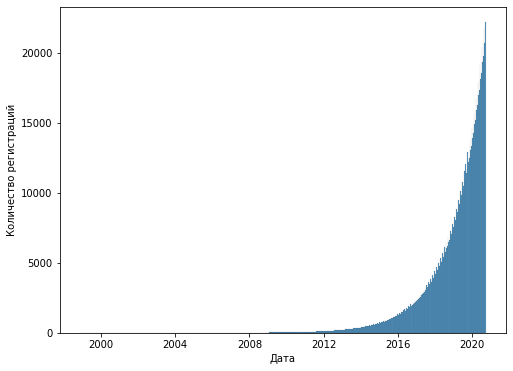

In [8]:
# Посмотрим на распределение данных во времени 
plt.figure(figsize=(8, 6))
sns.histplot(reg_data.reg_time)

plt.xlabel('Дата')
plt.ylabel('Количество регистраций')

plt.show()

Количество регистраций пользователей резко возрастает с 2016 года 

## Данные о времени захода пользователей в игру


In [9]:
auth_data.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


Дата-сет содержит следующую информацию:

auth_ts - данные о времени захода в игру
uid - id пользователя

In [10]:
auth_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9601013 entries, 0 to 9601012
Data columns (total 2 columns):
 #   Column   Dtype
---  ------   -----
 0   auth_ts  int64
 1   uid      int64
dtypes: int64(2)
memory usage: 146.5 MB


Дата-сет содержит более 9,5 млн. записей о действии пользователей в игре 
Пропущенных значений нет, колонка auth_ts требует изменения в формат даты (без учета времени захода, нам требуется информации о дне, когда пользователь возвращался в игру)

In [11]:
auth_data['auth_time'] = pd.to_datetime(auth_data.auth_ts, unit='s').dt.date.astype('datetime64')
auth_data.head()

,auth_ts,uid,auth_time
0,911382223,1,1998-11-18
1,932683089,2,1999-07-22
2,932921206,2,1999-07-25
3,933393015,2,1999-07-31
4,933875379,2,1999-08-05


In [12]:
#Проверим, сколько уникальных id пользователей содержит дата-сет 
auth_data['uid'].nunique()

1000000

In [13]:
#Определим, за какие года у нас есть данные 
auth_data['auth_time'].agg(['min', 'max'])

min   1998-11-18
max   2020-09-23
Name: auth_time, dtype: datetime64[ns]

Дата-сет содержит информацию о времени захода в игру 1 млн. пользователей, что совпадает с количеством пользователей, зарегистрировавшихся на платформе. 

У нас есть 2 дата-сета, в которых содержится информация о времени захода 1 млн. зарегистрированных пользователей в игру с 18.11.1998 по 23.09.2020. Это широкий диапозон дат, для retention такие временные рамки излишни. Поэтому функция для подсчета Retention будет брать на вход заданный диапозон дат 

## Функция для расчета retention 

Функция будет иметь следующий сценарий 

   - определить временной промежуток - data_start и data_finish --> фильтр дат 
   - объединить два дата-сета по id 
   - делаем когорты --> агреггировать данные по каждой дате
   - нужна колонка, где будет указан день от даты регистрации
   - считаем retention 
   - собираем в сводную таблицу pivot, где индекс - дата регистрации, колонка - день от даты регистрации, значения - retention
   - визуализируем данные через heatmap

In [171]:
def get_retention(reg_data, auth_data, start, finish):
    """
    Рассчитывает retention за заданный период времени.

    Параметры:
    reg_data (dataset): Данные о регистрации.
    auth_data (dataset): Данные о входе в игру.
    start (int64): Дата начала периода в формате 'yyyy-mm-dd'.
    finish (int64): Дата окончания периода в формате 'yyyy-mm-dd'.


    Возвращает:
    table: Таблица со значениями retention по дням.
    heatmap: Визуализация таблицы heatmap
    """
    #даты переводим в формат datetime
    start = pd.to_datetime(start)
    finish = pd.to_datetime(finish)
    #определяем временной диапозон, за который нам нужны данные для расчета retention
    reg_part = reg_data.query("@start <= reg_time and reg_time <= @finish")
    auth_part = auth_data.query("@start <= auth_time and auth_time <= @finish")
    
    #объединяем два дата-сета 
    users_data = reg_part.merge(auth_part, how='left', on='uid')
    
    #добавляем колонку day - для определения количества дней, прошедших со дня регистрации до входа пользователя
    users_data['day'] = (users_data['auth_time'] - users_data['reg_time']).dt.days
    
    #создаем когорты 
    cohorts = users_data.groupby(['reg_time', 'day'], as_index=False).agg({'uid':'nunique'})
    
    #создаем сводную таблицу 
    cohorts_table = cohorts.pivot(index='reg_time', columns='day', values='uid')
    
    #считаем retention
    users_retention = cohorts_table.divide(cohorts_table[0], axis=0)
    
    #уберем колонку с нулевым днем
    users_retention = users_retention.drop(0, axis=1)
    
    
    #добавляем визуализацию
    
    plt.figure(figsize=(20, 9))
    plt.title('Cohorts: User Retention')
    heatmap = sns.heatmap(data = users_retention,cmap="Blues", mask=users_retention.isnull(),annot=True,fmt='.0%')
    
    return users_retention

In [172]:
print(get_retention.__doc__)


    Рассчитывает retention за заданный период времени.

    Параметры:
    reg_data (dataset): Данные о регистрации.
    auth_data (dataset): Данные о входе в игру.
    start (int64): Дата начала периода в формате 'yyyy-mm-dd'.
    finish (int64): Дата окончания периода в формате 'yyyy-mm-dd'.


    Возвращает:
    table: Таблица со значениями retention по дням.
    heatmap: Визуализация таблицы heatmap
    


### Тестирование функции 

Проверим, как работает наша функция на небольших наборах данных за 2 разных периода.

day,1,2,3,4,5,6,7,8,9,10,11,12,13
reg_time,,,,,,,,,,,,,
2020-02-01,0.017010,0.046553,0.041182,0.045658,0.064458,0.063563,0.041182,0.042077,0.042972,0.044763,0.046553,0.042077,0.045658
2020-02-02,0.027703,0.033065,0.047364,0.054513,0.060769,0.070599,0.057194,0.053619,0.055407,0.058088,0.053619,0.058981,NaN
2020-02-03,0.016949,0.043711,0.046387,0.056200,0.062444,0.082070,0.049063,0.049955,0.051740,0.061552,0.049063,NaN,NaN
2020-02-04,0.024955,0.049020,0.047237,0.058824,0.059715,0.056150,0.059715,0.051693,0.054367,0.066845,NaN,NaN,NaN
2020-02-05,0.016889,0.042667,0.039111,0.054222,0.050667,0.067556,0.060444,0.044444,0.051556,NaN,NaN,NaN,NaN
2020-02-06,0.023979,0.039076,0.048845,0.052398,0.059503,0.085258,0.050622,0.045293,NaN,NaN,NaN,NaN,NaN
2020-02-07,0.019504,0.045213,0.039007,0.041667,0.070922,0.076241,0.056738,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-08,0.014159,0.034513,0.041593,0.034513,0.050442,0.059292,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-09,0.016784,0.047703,0.044170,0.049470,0.055654,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


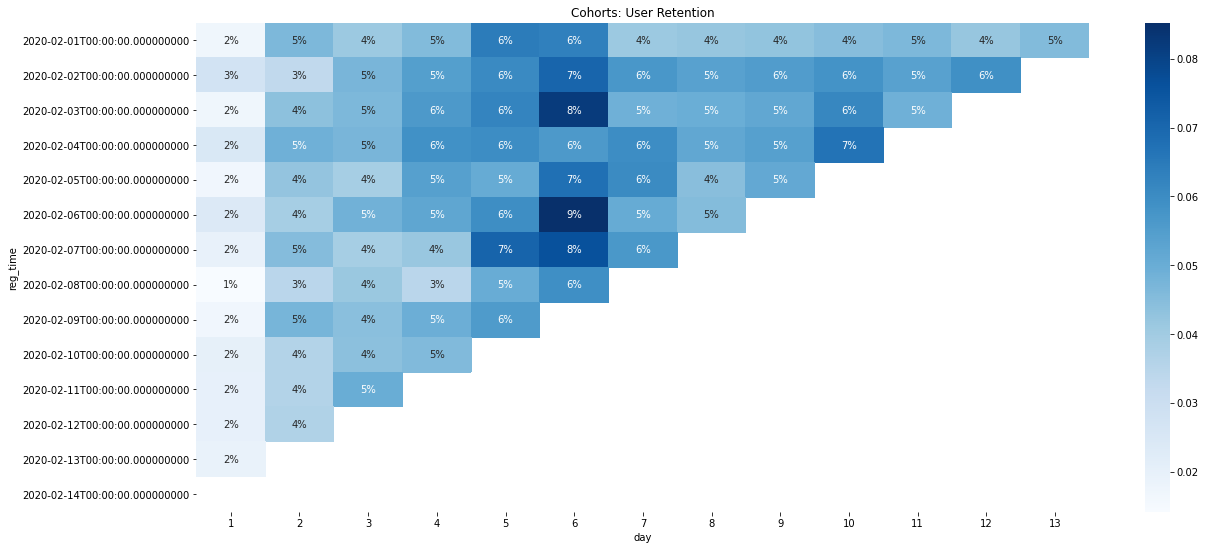

In [173]:
#Протестируем функцию на наборе данных за 01.02.2020 - 14.02.2020
start = '2020-02-01'
finish = '2020-02-14'

get_retention(reg_data, auth_data, start, finish)

day,1,2,3,4,5,6,7,8,9,10,11
reg_time,,,,,,,,,,,
2017-05-24,0.027027,0.027027,0.031532,0.067568,0.054054,0.067568,0.054054,0.063063,0.031532,0.040541,0.063063
2017-05-25,0.036036,0.049550,0.040541,0.058559,0.045045,0.099099,0.058559,0.067568,0.036036,0.067568,NaN
2017-05-26,0.017937,0.044843,0.053812,0.053812,0.049327,0.067265,0.058296,0.067265,0.058296,NaN,NaN
2017-05-27,0.031390,0.035874,0.049327,0.031390,0.040359,0.071749,0.022422,0.026906,NaN,NaN,NaN
2017-05-28,0.004484,0.067265,0.017937,0.035874,0.085202,0.085202,0.053812,NaN,NaN,NaN,NaN
2017-05-29,0.017857,0.035714,0.017857,0.071429,0.066964,0.053571,NaN,NaN,NaN,NaN,NaN
2017-05-30,0.008929,0.035714,0.053571,0.066964,0.058036,NaN,NaN,NaN,NaN,NaN,NaN
2017-05-31,0.008929,0.053571,0.044643,0.044643,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-06-01,0.022222,0.017778,0.044444,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


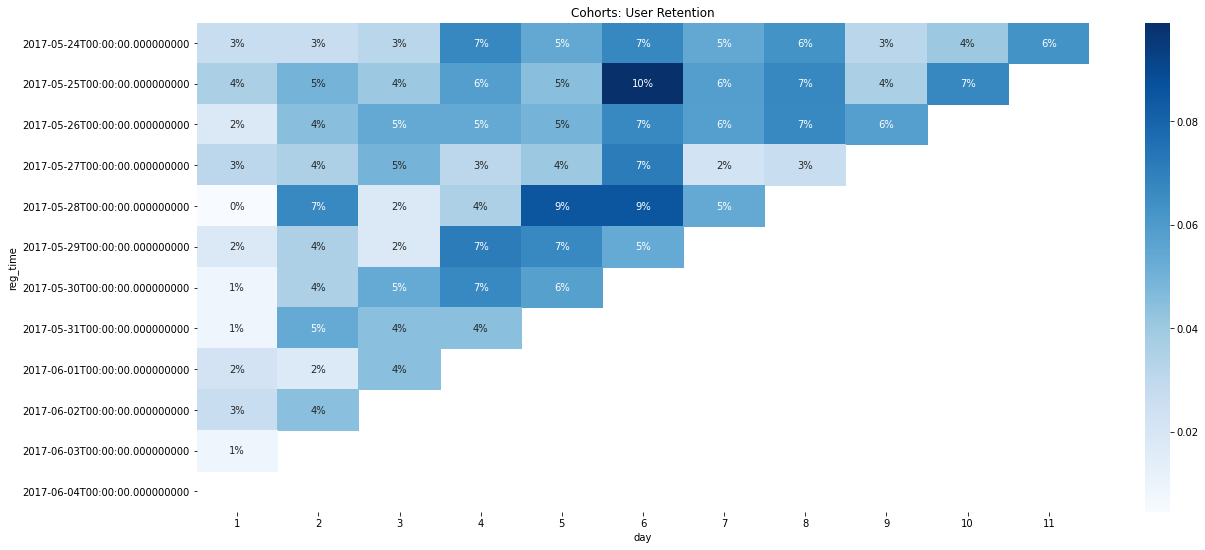

In [174]:
#Протестируем функцию на наборе данных за 24.05.2018 - 04.06.2018
start = '2017-05-24'
finish = '2017-06-04'

get_retention(reg_data, auth_data, start, finish)

# Задача 2

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. 
Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [17]:
#считываем и загружаем данные для работы с Yandex Диска
#функция для загрузки данных 
def down_data(pulic_key, sep = ';'):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    data_url = pulic_key
    final_url = base_url + urlencode(dict(public_key = data_url))
    # Делаем запрос через requests и вытягивыем нужную информацию
    response = requests.get(final_url)
    download_url = response.json()['href']
 # Считываем информацию
    data = pd.read_csv(download_url, sep = sep)
    
    return data

In [18]:
testing_url = 'https://disk.yandex.ru/d/SOkIsD5A8xlI7Q'
testing_df = down_data(testing_url)

In [19]:
testing_df.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


## Разведочный анализ данных

In [20]:
testing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB


Наши данные содержат 404 770 записей, колонки с информацией об id пользователей, размере выручки с пользователя и к какой группе принадлежит пользователь - контрольной (a) или тестовой (b). Пропусков в данных нет

In [21]:
#Посмотрим, сколько пользователей находится в каждой группе
testing_df.groupby('testgroup', as_index=False) \
          .agg({'user_id':'nunique'})

,testgroup,user_id
0,a,202103
1,b,202667


В контрольной группе у нас 202 103 уникальных пользователей, в тестовой - 202 667 уникальных пользователей.

In [81]:
#Посмотрим, сколько в каждой группе платящих пользователей
#разобъем данные на два дата-сета - контрольная и тестовая группа
#a - контрольная группа
#b - тестовая группа

group_a = testing_df.query('testgroup == "a"')
group_b = testing_df.query('testgroup == "b"')

#и отдельные дата-сеты с только платящими пользователями 
payed_a = group_a.query('revenue > 0') 
payed_b = group_b.query('revenue > 0')
                                           
print(payed_a['user_id'].nunique(), 'платящих пользователей в контрольной группе')
print(payed_b['user_id'].nunique(), 'платящих пользователей в тестовой группе')

1928 платящих пользователей в контрольной группе
1805 платящих пользователей в тестовой группе


In [82]:
group_a

,user_id,revenue,testgroup
1,2,0,a
2,3,0,a
9,10,0,a
10,11,0,a
11,12,0,a
...,...,...,...
404760,404761,0,a
404762,404763,0,a
404765,404766,0,a
404767,404768,231,a


Теперь посмотрим на распределение данных внутри каждой группы. Нас будут интересовать платящие пользователи

In [83]:
#Платящие пользователи в контрольной группе
payed_a.describe()

,user_id,revenue
count,1928.000000,1928.000000
mean,200152.677905,2663.998444
std,116596.504905,9049.039763
min,73.000000,200.000000
25%,99323.000000,257.000000
50%,199854.500000,311.000000
75%,299664.250000,361.000000
max,404768.000000,37433.000000


In [84]:
#Платящие пользователи в тестовой группе
payed_b.describe()

,user_id,revenue
count,1805.000000,1805.000000
mean,205834.548476,3003.658172
std,116400.045485,572.619709
min,161.000000,2000.000000
25%,106815.000000,2513.000000
50%,206651.000000,3022.000000
75%,304907.000000,3478.000000
max,404526.000000,4000.000000


*Из описательной статистики видно, что*:

 - Среднее значение revenue в двух группах отличается 2 663 в контрольной и 3 003.6 в тестовой.
 - Медианное значение revenue существенно отличается в двух группах - в 9.7 раз в пользу тестовой группы. 
 - В контрольной группе могут присутствовать крупные выбросы - медиана и среднее отличаются друг от друга в несколько раз, максимальное значение revenue в контрольной группе - 37 433 при медиане 311.

Посмотрим на распределение данных в каждой группе на графиках

**Диаграмма распределения**

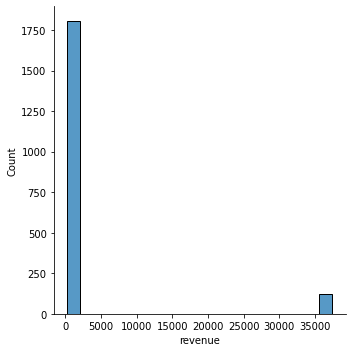

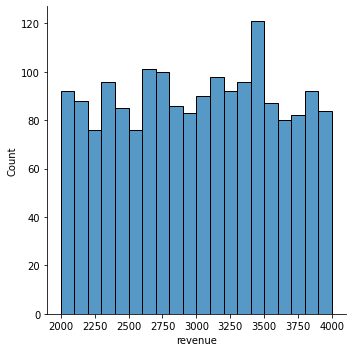

In [85]:
sns.displot(payed_a.revenue, bins=20) #график контрольной группы
sns.displot(payed_b.revenue, bins=20) #график тестовой группы

**Боксплот**

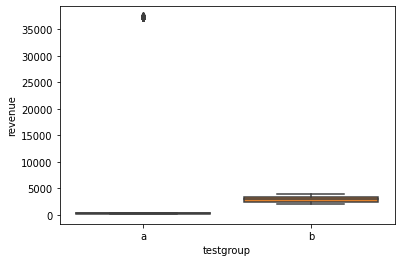

In [86]:
sns.boxplot(data=testing_df.query('revenue > 0'), y='revenue', x='testgroup')

Из графиков видно следующее:
 - распределение в обеих группах визуально выглядит как ненормальное.
 - в контрольной группе большинство пользователей совершали платежи в пределах 0 - 3 000. И небольшая выборка пользователей совершила платеж более 35 000. На графике боксплот видно, что в контрольной группе есть крупные выбросы. 
 - в тестовой группе пользователи совершали платеж от 2 000 до 4 000.
 

Посмотрим на распределние данных в контрольной группе. Нас интересуют платящие пользователи - те, чье значение retention очень высокое и распределение значений других пользователей

In [95]:
#сколько у нас пользователей с очень высокими платежами, выше 30000 
check_hire = payed_a.query('revenue > 30000') \
       .agg({'user_id':'nunique'})
check_hire

user_id    123
dtype: int64

In [101]:
#сколько процентов от всей платящей аудитории они составляют
check_pr = round(check_hire / payed_a.user_id.nunique() * 100, 2)
check_pr

user_id    6.38
dtype: float64

In [90]:
#посмотрим, сколько выручки приходится на этот сегмент пользователей
revenue_hire = payed_a.query('revenue > 30000').agg({'revenue':'sum'})
revenue_hire

revenue    4590252
dtype: int64

In [94]:
#сколько процентов от всей выручки составляет выручка этого сегмента
revenue_pr = round(revenue_hire / group_a.revenue.sum() * 100, 2)
revenue_pr

revenue    89.37
dtype: float64

На 123 пользователя с revenue выше 30000 (6.4% от всех платящих пользователей) приходится 89.4% всей выручки

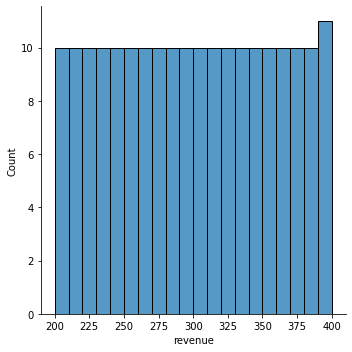

In [88]:
#сколько у нас остальных платящих пользователей и их распределение по размеру чека
payed_less = payed_a.query('revenue > 0 and revenue < 30000') \
                    .groupby('revenue', as_index=False) \
                    .agg({'user_id':'nunique'})
                   

sns.displot(payed_less.revenue, bins=20)

**Выводы**
В контрольной группе у нас оказались пользователи с низкими платежами (от 200 до 400) и пользователи со высокими платежами (более 30 000, таких пользователей около 6% от всей контрольной группы).
В тестовой группе у нас оказались пользователи со средними платежами - от 2 000 до 4 000. 

В контрольную группу могли попасть пользователи, которым предлагались акции на какие-то длительные предложения/подписки или эксклюзивный кастом персонажа, аммуниция. В то время как остальным пользователям с низкими платежами и пользователям тестововй группы предлагались скидочные купоны или фиксированный размер среднего или небольшого бонуса в виде игровой валюты. Нам не хватает дополнительных данных, чтобы точно сказать, почему в контрольной группе оказались пользователи с высокими чеками, которые сильно сместили среднее значение по платежам вправо (2663 при медиане 311).  

Еще одно предположение, почему могло получится такое формирование контрольной и тестовой групп - изначальный недочет при дизайне исследования, который привел к неккоректному сплитованию. Но для такого вывода нужны дополнительные данные - какой тип акционных предложений предлагался пользователям + иная дополнительная информация, чтобы корректно определить принадлежность к сегментам аудитории. 

В нашем анализе мы будем исходить из первого предложения - A/B тестирование проведено корректно, некоторым пользователям в тестовой группе предлагались акции на более высокие по цене покупки 



### Метрики для анализа

У нас есть следующая информация о пользователях - к какой группе относится пользователь, размер выручки от одного пользователя, количество всех пользователей в группе.

Исходя из этой информации, мы можем считать следующие метрики для оценки качества предложений:
 - ARPU средний доход на каждого пользователя
 - ARPPU средний доход на каждого платящего пользователя
 - Конверсия в платящего пользователя


#### Метрика CR конверсия в платящего пользователя

In [66]:
#конверсия в контрольной группе
CR_a = payed_a['user_id'].nunique() / group_a['user_id'].nunique()
CR_a

0.009539690157988749

In [39]:
#конверсия в тестовой группе
CR_b = payed_b['user_id'].nunique() / group_b['user_id'].nunique()
CR_b

0.008906235351586593

In [69]:
#разница конверсий двух групп
CR_diff = (CR_b - CR_a) / CR_a * 100
CR_diff

-6.640203150326494

Конверсия в контрольной группе выше, чем конверсия в тестовой примерно на 6.64% 

#### Метрика ARPU средний доход с каждого пользователя

In [70]:
#ARPU контрольной группы 
ARPU_a = round(group_a.revenue.sum() / group_a.user_id.count(), 2)
ARPU_a

25.41

In [71]:
#ARPU тестовой группы 
ARPU_b  = round(group_b.revenue.sum() / group_b.user_id.count(), 2)
ARPU_b 

26.75

In [73]:
#разница ARPU в двух группах
ARPU_diff = round((ARPU_b - ARPU_a) / ARPU_a * 100, 2)
ARPU_diff

5.27

ARPU в тестовой группе выше ARPU контрольной группы на 5.27%

#### Метрика ARPPU средний доход с каждого платящего пользователя

In [78]:
#ARPPU контрольной группы 
ARPPU_a = round(ARPU_a / CR_a, 2)
ARPPU_a

2663.61

In [79]:
#ARPPU тестовой группы 
ARPPU_b = round(ARPU_b / CR_b, 2)
ARPPU_b

3003.51

In [80]:
#разница ARPPU в двух группах
ARPPU_diff = round((ARPPU_b - ARPPU_a) / ARPPU_a * 100, 2)
ARPPU_diff

12.76

ARPPU в тестовой группе выше ARPPU контрольной группы на 12.76%

#### Проверим тестовую и контрольную группу на нормальность и однородность распределения данных

In [109]:
#проверка на нормальность распределения данных в контрольной группе
pg.normality(group_a.query('revenue > 0'))

,W,pval,normal
user_id,0.954992,6.270089e-24,False
revenue,0.266792,0.000000e+00,False


In [110]:
#проверка на нормальность распределения данных в тестовой группе
pg.normality(group_b.query('revenue > 0'))

,W,pval,normal
user_id,0.957396,1.453523e-22,False
revenue,0.958312,2.491346e-22,False


Обе группы имеют ненормальное распределение 

In [102]:
#проверка на однородность распределения данных
from scipy.stats import levene

# Пример использования теста Левена
statistic, p_value = levene(payed_a['revenue'], payed_b['revenue'])

# Вывод результатов теста
print('Статистика теста Левена:', statistic)
print('p-значение теста Левена:', p_value)

Статистика теста Левена: 80.85567421779912
p-значение теста Левена: 3.779689868667878e-19


Полученное значение p-value значительно меньше заданного уровня значимости в 5%. Поэтому мы отвергаем нулевую гипотезу и делаем вывод о неоднородности дисперсий между группами. 

### Статистические тесты 

#### Метрика CR

Для сравнения значения конверсий в двух группах мы будем использовать критерий X-квадрат, так как это категориальная переменная - конверсия либо есть, либо ее нет у пользователя. 
- Нулевая гипотеза - отсутствуют статистически значимые различия между конверсиями двух групп 
- Альтернативная гипотеза - есть статистически значимые различия между конверсиями двух групп 

уровень значимости - 5% (0.05)

In [117]:
#создаем новыйй столбец в testing_df, где 0 - конверсии нет, а 1 - конверсия есть 
testing_df['paid/nopaid'] = testing_df['revenue'].apply(lambda x: 1 if x > 0 else 0)

# Создание таблицы сопряженности
crosstab_result = pd.crosstab(testing_df['paid/nopaid'], testing_df['testgroup'])
crosstab_result

testgroup,a,b
paid/nopaid,,
0,200175,200862
1,1928,1805


In [118]:
#Выполняем тест хи-квадрат
from scipy.stats import chi2_contingency
chi2, p, dof, expected = chi2_contingency(crosstab_result)

print("Хи-квадрат статистика:", chi2)
print("p-значение:", p)

Хи-квадрат статистика: 4.374729521260405
p-значение: 0.03647561892312613


Полученное значение p-value не превышает 5% уровень значимости (тест показал 0.036). Следовательно, мы можем отклонить нулевую гипотезу и принять альтернативную, что конверсии между двумя группами статистически различаются

#### Метрика ARPU
В тестовой группе из-за наличия выбросов, а также ненормальности распределений в обеих группах, мы будем использовать метод bootstrap для сравнения двух средних в группах 
- Нулевая гипотеза - среднее значение выручки одного пользователя в тестовой группе статистически значимо не отличается от среднего значения выручки одного пользователя в контрольной группе
- Альтернативная гипотеза - среднее значение выручки одного пользователя в тестовой группе статистически значимо отличается от среднего значения выручки одного пользователя в контрольной группе

если 0 входит в доверительный интервал, то мы принимаем нулевую гипотезу, если 0 не входит в доверительный интервал - отвергаем нулевую гипотезу и принимаем альтернативную 


In [167]:
#данные о выручке пользователей контрольной и тестовой групп
group1 = group_a.revenue
group2 = group_b.revenue

num_samples = 1000
bootstrap_diff_means = np.zeros(num_samples)


for i in range(num_samples):
    bootstrap_sample1 = np.random.choice(group1, size=len(group1), replace=True)
    bootstrap_sample2 = np.random.choice(group2, size=len(group2), replace=True)
    
    bootstrap_mean1 = np.mean(bootstrap_sample1)
    bootstrap_mean2 = np.mean(bootstrap_sample2)
    
    bootstrap_diff_means[i] = bootstrap_mean1 - bootstrap_mean2
    
# Вычисление 95%-го доверительного интервала для разницы средних
interval = np.percentile(bootstrap_diff_means, [2.5, 97.5])

# Рассчитываем p-value 
mean_observ = np.mean(group1) - np.mean(group2)
p_value = np.mean(np.abs(bootstrap_diff_means) >= np.abs(mean_observ))

print("95% доверительный интервал:", interval)
print("p-значение:", p_value)

95% доверительный интервал: [-5.75010277  2.87703165]
p-значение: 0.625


Доверительный интервал лежит в диапозоне от -5.75 до 2.87. Ноль входит в данный диапозон, p-value = 0.625, мы не можем отклонить нулевую гипотезу. Между средними значениями выручки на одного пользователи контрольнйо и тестовой группы нет статистически значимых отличий. 

#### Метрика ARPPU -  средний доход с каждого платящего пользователя

мы будем также использовать метод bootstrap для сравнения двух средних в группах

Нулевая гипотеза - среднее значение выручки одного платящего пользователя в тестовой группе статистически значимо не отличается от среднего значения выручки одного платящего пользователя в контрольной группе
Альтернативная гипотеза - среднее значение выручки одного платящего пользователя в тестовой группе статистически значимо отличается от среднего значения выручки одного платящего пользователя в контрольной группе

In [170]:
#данные о выручке платящих пользователей контрольной и тестовой групп payed_a и payed_b
group_1 = payed_a.revenue
group_2 = payed_b.revenue

num_samples = 1000
bootstrap_diff = np.zeros(num_samples)


for i in range(num_samples):
    bootstrap_sample_1 = np.random.choice(group_1, size=len(group_1), replace=True)
    bootstrap_sample_2 = np.random.choice(group_2, size=len(group_2), replace=True)
    
    bootstrap_mean_1 = np.mean(bootstrap_sample_1)
    bootstrap_mean_2 = np.mean(bootstrap_sample_2)
    
    bootstrap_diff[i] = bootstrap_mean_1 - bootstrap_mean_2
    
# Вычисление 95%-го доверительного интервала для разницы средних
interval = np.percentile(bootstrap_diff, [2.5, 97.5])

# Рассчитываем p-value 
mean_observation = np.mean(group_1) - np.mean(group_2)
p_value = np.mean(np.abs(bootstrap_diff) >= np.abs(mean_observation))

print("95% доверительный интервал:", interval)
print("p-значение:", p_value)

95% доверительный интервал: [-721.08692624   69.28386343]
p-значение: 0.503


Доверительный интервал лежит в диапозоне от -721 до 69.3. Ноль входит в данный диапозон, p-value = 0.503, мы не можем отклонить нулевую гипотезу. Между средними значениями выручки платящего пользователи контрольной и тестовой группы нет статистически значимых отличий.

### Выводы
1. Наборы акционных предложений не повлияли на значения ARPU и ARPPU в тестовой и контрольной группах, имеющиеся различия статистически не значимы
2. Конверсия в покупки выше в контрольной группе, эти различия статистически значимы. 

**Акционные предложения не влияют на размер выручки, они требуют доработки и на данный момент не могут быть внедрены для всех пользователей**

в тестовой группе есть выбросы, которые повлияли на размер среднего чека в сторону увеличения - их стоит дополнительно проанализировать, выявить причину их появления только в одной группе 

# Задача 3.

В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

В другом событии усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад.

**Метрики для оценивания последнего прошедшего события с механикой выдачи награды**

- Retention:
Retention 1 дня - сколько уникальных игроков участвовали в первом дне события. Retention N-дня - % игроков, продолживших играть после первого входа в игру на тематическом событии, которое длится несколько дней. Либо это может быть Retention 30 минут, Retention N-часа - если тематическое событие ограничено несколькими часами. 

- Конверсия пользователей - оценка, какая часть пользователей, участвовавших в тематическом событии в 1 раз, переходят в активные пользователи и доходят до следующего тематического события.

- Return Rate - процент возврата в игру пользователей, уже игравших ранее. Можно оценивать, какая часть игроков возвращается в игру постоянно только во время тематических событий, а какая часть вовзращается и в обычные дни.
Регулярность входа в игру - насколько часто пользователь запускает игру. Временной промежуток час/день/неделя/месяц. В тематические события с механикой бонусов оба показатели будут выше, чем в обычные дни. 

- Churn Rate - процент потери аудитории. Какой процент аудитории уходит во время тематических событий и в обычные дни. В тематические дни показатель будет снижаться, если механика тематического дня - получение дополнительных бонусов за прохождение игры.  

- Успешность игроков - какая часть игроков полностью прошла тематическое событие, прошла 80-50-25% сюжета тематического события.

- Средний % полученных предметов - сколько пользователей получили более 90-80-50-иной процент разыгрываемых предметов.

- Среднее время игровой сессии - сколько времени игрок проходит в игре за 1 вход. В тематическом событии с бонусами и ограниченным временем показатель может снизиться. 

- Среднее количество пройденных уровней за N-период - сколько в среднем 1 игрок проходит уровней за день/неделю/другой временной промежуток. В тематические события показатель может быть выше, чем в обычные дни.

- Оценка/отзывы пользователей 

*дополнительная метрика
Если в игре есть платные товары, то можно оценить: какие категории товаров приобретает игрок во время тематического события и в обычные дни, сколько товаров в среднем приобретает игрок и средний платеж на пользователя (ARPU/ARPPU) в обычные дни и тематические. 

**Метрики для оценивания тематического события с откатом уровней**

Здесь игрокам предлагается механика штрафной системы - когда за 1 недучную попытку пользователь откатывается на N-уровней назад. В этом случае набор метрик изменится.

 
- Retention N-дня - сколько пользователей возвращаются в игру после участия в 1 дне/1 часе тематического события. Из-за усложнения механики значения метрики могут быть ниже, чем в обычные дни. 

- Конверсия пользователей - сколько новых пользователей переходят в категорию активных пользователей. 

- Return Rate - процент возврата в игру пользователей, уже игравших ранее. 

- Churn Rate - процент потери аудитории. Можно считать в разных разрезах - уровни/период времени

- Успешность игроков - какая часть игроков успешно завершило тематическое событие, прошла все уровни, которые относились к тематическому событию. 

- Среднее время игровой сессии за 1 вход - можно считать когортами, основываясь на количество пройденных уровней. Сколько времени пользователь провел за игрой при прохождении 1-3 уровней, 4-5 уровней и далее. 

- Среднее время нахождения на 1 уровне - сколько в среднем 1 пользователь удерживал свой уровень во время прохождения игры. 

- Среднее количество пройденных уровней за N-период - из-за усложнения механики может уменьшиться. 
- Среднее количество попыток - сколько в среднем 1 пользователь пытался пройти 1 уровень

- Оценка/отзывы пользователей 

